In [1699]:
import json
import numpy as np
import requests
import pandas as pd
from datetime import datetime as dt
from datetime import date, timedelta

def datetime_to_timestamp(datetime_obj): 
    """Converts a datetime object to a Unix timestamp in milliseconds."""
    return int(dt.timestamp(datetime_obj)*1000)

def timestamp_to_datetime(timestamp): 
    """Converts a Unix timestamp in milliseconds to a datetime object."""
    return dt.fromtimestamp(timestamp/1000)

In [1700]:
from collections import namedtuple

base_url = 'https://www.deribit.com/api/v2/public/'
Option = namedtuple('Option', ['name', 'kind', 'expiry', 'strike', 'delta', 'gamma', 'vega', 'theta', 'bid', 'ask'])
def get_index(instr):
    url = base_url + 'ticker'
    with requests.Session() as session:
        response = session.get(url, params={'instrument_name': instr})
        data = response.json()
        return data['result']['index_price']
    
def get_bbo(option):
    url = base_url + 'ticker'
    with requests.Session() as session:
        response = session.get(url, params={'instrument_name': option.name})
        data = response.json()
        res = data['result']
        greeks = res['greeks']
        return option._replace(delta=greeks['delta'],
                               gamma = greeks['gamma'],
                               theta = greeks['theta'],
                               vega = greeks['vega'],
                               bid = res['best_bid_price'] if res['best_bid_price'] is not None else 0,
                               ask = res['best_ask_price'] if res['best_ask_price'] is not None else np.infty)
    
def get_options(curr, min_strike, index, max_strike, min_days, max_days):
    url = base_url + 'get_instruments'
    now = dt.today()
    instruments = {}

    with requests.Session() as session:
        response = session.get(url, params={'currency':curr, 'kind':'option', 'expired': 'false'})
        response_data = response.json()
        options = response_data['result']
        
        for option in options:
            strike = int(option['strike'])
            expiry = option['expiration_timestamp']
            expiry = timestamp_to_datetime(int(expiry))
            days_left = (expiry - now).days
            
            if days_left <= max_days and days_left >= min_days and strike > min_strike and strike < max_strike:
                if days_left not in instruments:
                    instruments[days_left] = {}
                
                if strike not in instruments[days_left]:
                    instruments[days_left][strike] = {}
                
                option_type = option['option_type']
                
                if option_type == 'call' and strike < index:
                    continue
                
                if option_type == 'put' and strike > index:
                    continue
                    
                if option_type not in instruments[days_left][strike]:
                    instruments[days_left][strike][option_type] = option['instrument_name']
                
    return instruments

In [1701]:
underlying = 'BTC'
idx_price = get_index(underlying + '-PERPETUAL')
min_strike = idx_price * 0.8
max_strike = idx_price * 1.2

valid_options = get_options(underlying, min_strike, idx_price, max_strike, 1, 25)

In [1702]:
print(valid_options.keys())

dict_keys([1, 3, 10, 17])


In [1703]:
options = []

for expiry in valid_options:
    for strike in valid_options[expiry]:
        for option_type in valid_options[expiry][strike]:
            options.append(Option(valid_options[expiry][strike][option_type], 
                                  1 if option_type == 'call' else -1,
                                  expiry, strike, 0, 0, 0, 0, 0, 0))

In [1704]:
from tqdm import tqdm
option_data = []

for option in tqdm(options):
    d = get_bbo(option)
    if (d.bid > 0 and d.ask < np.infty):# and (d.ask - d.bid) < 0.001:
        option_data.append(d)

100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:56<00:00,  1.29it/s]


In [1705]:
import cvxpy as cvx

In [1706]:
N = len(option_data)
print(N)

expiries = set()

for i in range(0, N):
    expiries.add(option_data[i].expiry)
    
print(min(expiries))

73
1


In [1707]:
deltas = np.zeros(N)
gammas = np.zeros(N)
vegas = np.zeros(N)
thetas = np.zeros(N)
bids = np.zeros(N)
asks = np.zeros(N)
calls = np.zeros(N)
puts = np.zeros(N)
strikes = np.zeros(N)

for i in range(0, N):
    deltas[i] = option_data[i].delta
    gammas[i] = option_data[i].gamma
    vegas[i] = option_data[i].vega
    thetas[i] = option_data[i].theta
    bids[i] = option_data[i].bid
    asks[i] = option_data[i].ask
    calls[i] = max(option_data[i].kind, 0)
    puts[i] = min(option_data[i].kind, 0)
    strikes[i] = option_data[i].strike

In [1708]:
x = cvx.Variable((1, N), integer=True)
y = cvx.Variable((1, N), integer=True)

In [1709]:
obj = cvx.Minimize(x@asks +y@bids)

In [1710]:
cons = [(x+y)@deltas <= .01, 
        (x+y)@deltas >= -.01, 
        (x+y)@vegas >= 0, 
        (x+y)@puts == 0,
        (x+y)@calls == 0,
        x <= 14, x >= 0,
        y <= 0, y >= -14,
        cvx.sum(x) <= 125,
        cvx.sum(y) >= -125,
        (x+y)@thetas >= 10,
        (x+y)@gammas >= 0.001,
        cvx.multiply(x[0, :], calls)@strikes >= 0,
        cvx.multiply(y[0, :], puts)@strikes <= 0,
       ]

In [1711]:
prob = cvx.Problem(objective=obj, constraints=cons)
prob.solve(verbose=1)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Mar 13 10:34:49 PM: Your problem has 146 variables, 15 constraints, and 0 parameters.
(CVXPY) Mar 13 10:34:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 13 10:34:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 13 10:34:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 13 10:34:49 PM: Compiling problem (target solver=GLPK_MI).
(CVXPY) Mar 13 10:34:49 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

-0.3895000000000004

In [1712]:
positions = x.value[0, :] + y.value[0, :]

In [1713]:
print("theta=", np.dot(positions, thetas), "gamma=", np.dot(positions, gammas))

theta= 15.168360000000177 gamma= 0.002330000000000001


In [1714]:
total_cost = 0
buy_cost = 0
sell_cost = 0
instr_pos = {}
op_list = []
selects = {}
net_gamma = 0
fees = 0
for i in range(0, N):
    if positions[i] != 0:
        instr_pos[option_data[i]] = positions[i]
        cost = positions[i] * (option_data[i].bid if positions[i] < 0 else option_data[i].ask)
        fees += min(abs(positions[i] * 0.0006), abs(cost) * 0.125)
        buy_cost += max(cost, 0)
        sell_cost += min(cost, 0)
        net_gamma += positions[i] * option_data[i].gamma
        print(option_data[i].name, "size=", positions[i], "theta=", 
              option_data[i].theta * positions[i], "gamma=", option_data[i].gamma * positions[i], "cost=", cost)
        
        op = {'op_type': 'c' if option_data[i].kind > 0 else 'p',
              'strike': option_data[i].strike,
              'tr_type': 'b' if positions[i] > 0 else 's',
              'op_pr': option_data[i].bid if positions[i] < 0 else option_data[i].ask,
              'contract': abs(positions[i])}
        op_list.append(op)
        selects[option_data[i].name] = positions[i]
        total_cost += cost

BTC-15MAR23-24000-C size= 9.0 theta= -1611.7938 gamma= 0.00216 cost= 0.17099999999999999
BTC-15MAR23-25000-C size= -14.0 theta= 2051.57694 gamma= -0.00238 cost= -0.112
BTC-15MAR23-25500-C size= -14.0 theta= 1658.13578 gamma= -0.0018199999999999998 cost= -0.077
BTC-15MAR23-26000-C size= -14.0 theta= 1199.91424 gamma= -0.0014 cost= -0.056
BTC-17MAR23-24000-C size= 13.0 theta= -1329.4867299999999 gamma= 0.0026000000000000003 cost= 0.3185
BTC-17MAR23-24500-C size= 14.0 theta= -1346.76178 gamma= 0.00252 cost= 0.24500000000000002
BTC-17MAR23-25000-C size= 14.0 theta= -1217.25996 gamma= 0.0022400000000000002 cost= 0.182
BTC-17MAR23-25500-C size= 11.0 theta= -854.0018299999999 gamma= 0.0014299999999999998 cost= 0.1045
BTC-17MAR23-27000-C size= -13.0 theta= 660.46084 gamma= -0.0009099999999999999 cost= -0.0455
BTC-17MAR23-28000-C size= -14.0 theta= 508.00302 gamma= -0.0005600000000000001 cost= -0.028
BTC-24MAR23-24000-C size= -14.0 theta= 738.4775999999999 gamma= -0.00196 cost= -0.518
BTC-24MAR

In [1715]:
print(net_gamma)
premium = total_cost * idx_price
print(premium)
fee_dollar = fees * idx_price
print("net income after fees=", -premium-fee_dollar, premium, fee_dollar)

0.00233
-9187.53379
net income after fees= 5847.7650082499995 -9187.53379 3339.76878175


In [1716]:
net_delta = np.dot(positions, deltas)
print(net_delta)

-0.007329999999999615


In [1717]:
import json
def get_portfolio_margin(pos, curr):
    url = base_url + 'get_portfolio_margins'
    with requests.Session() as session:
        response = session.get(url, params={'currency':curr, 'simulated_positions': json.dumps(pos)})
        response_data = response.json()
        return response_data

In [1718]:
posnow = {}
poslater = {}

for k, v in instr_pos.items():
    posnow[k.name] = v
    
    if k.expiry > min(expiries):
        poslater[k.name] = v

res = get_portfolio_margin(posnow, underlying)
margin = res['result']['margin']
print("margin right now=", margin * idx_price)

res = get_portfolio_margin(poslater, underlying)
margin_later = res['result']['margin']
print("margin after 1st expiry=", margin_later * idx_price)

margin right now= -11176.829565845297
margin after 1st expiry= -11901.477456497782


In [1719]:
print("profit after fees=", -premium-fee_dollar, "capital=", (abs(net_delta) + abs(margin)) * idx_price)

profit after fees= 5847.7650082499995 capital= 11349.729752445288


In [1720]:
import opstrat

In [1721]:
def get_data(instr):
    url = base_url + 'ticker'
    with requests.Session() as session:
        response = session.get(url, params={'instrument_name': instr})
        data = response.json()
        res = data['result']
        greeks = res['greeks']
        delta=greeks['delta']
        gamma = greeks['gamma']
        theta = greeks['theta']
        vega = greeks['vega']
        bid = res['best_bid_price'] if res['best_bid_price'] is not None else 0
        ask = res['best_ask_price'] if res['best_ask_price'] is not None else np.infty
        return bid, ask, delta, gamma, theta, vega

In [1722]:
'''cost = 0
net_theta = 0
net_gamma = 0
net_delta = 0
net_vega = 0
for (opt, sz) in tqdm(selects.items()):
    data = get_data(opt)
    cost += sz * data[0] if sz < 0 else sz * data[1]
    net_theta += sz * data[4]
    net_gamma += sz * data[3]
    net_delta += sz * data[2]
    net_vega += sz * data[5]
'''

'cost = 0\nnet_theta = 0\nnet_gamma = 0\nnet_delta = 0\nnet_vega = 0\nfor (opt, sz) in tqdm(selects.items()):\n    data = get_data(opt)\n    cost += sz * data[0] if sz < 0 else sz * data[1]\n    net_theta += sz * data[4]\n    net_gamma += sz * data[3]\n    net_delta += sz * data[2]\n    net_vega += sz * data[5]\n'

In [1723]:
#print(cost, net_theta, net_gamma, net_delta, net_vega)

23588.02


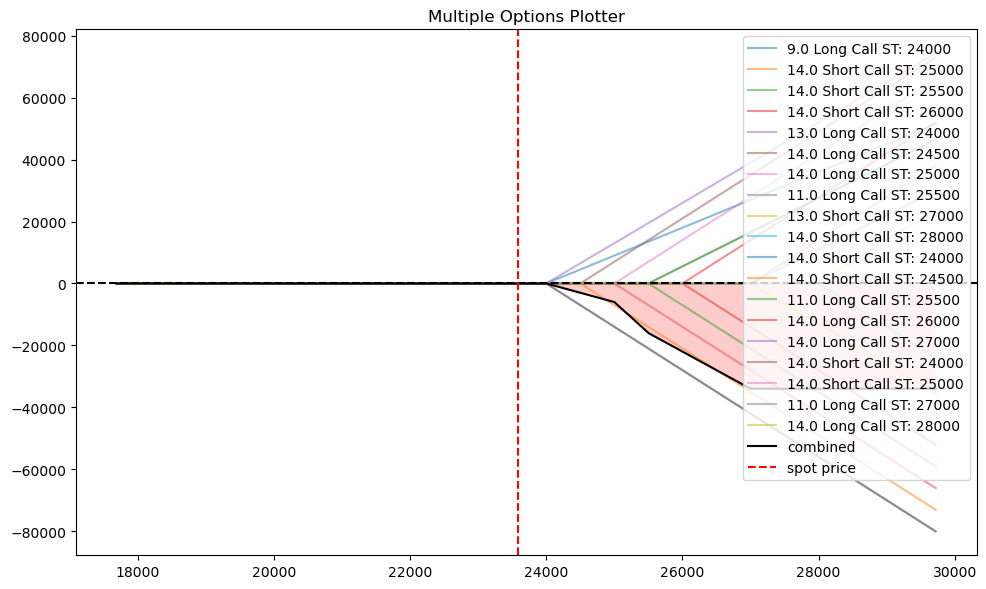

In [1724]:
print(idx_price)
opstrat.multi_plotter(spot=idx_price, spot_range=25, op_list=op_list)